<a href="https://colab.research.google.com/github/jaswanthBavi/Green-Watt-Energy-Solution-Major_project/blob/main/Green_Watt_Energy_major_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install lightgbm joblib shap matplotlib pandas scikit-learn --quiet

1. Imports

In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

2. Paths & basic config

In [8]:
df = pd.read_csv("train.csv")  # <-- update path if needed
print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())

Dataset shape: (22727, 16)
Columns: ['timestamp', 'active_power_calculated_by_converter', 'active_power_raw', 'ambient_temperature', 'generator_speed', 'generator_winding_temp_max', 'grid_power10min_average', 'nc1_inside_temp', 'nacelle_temp', 'reactice_power_calculated_by_converter', 'reactive_power', 'wind_direction_raw', 'wind_speed_raw', 'wind_speed_turbulence', 'turbine_id', 'Target']


Identify Target Column

In [9]:
POSSIBLE_TARGETS = ['Target', 'target', 'power', 'Power', 'power_output', 'PowerOutput']
target_col = next((col for col in df.columns if col in POSSIBLE_TARGETS), None)

if target_col is None:
    raise ValueError(" No target column found. Please set it manually.")
print("\nUsing target column:", target_col)


Using target column: Target


Identify numerical and categorical features


In [10]:
numerical_features = df.select_dtypes(include=np.number).columns.tolist()
numerical_features = [col for col in numerical_features if col not in ['timestamp', target_col]]

# If turbine_id exists, treat it as categorical
categorical_features = [col for col in df.columns if col == 'turbine_id']

print("\nNumerical features identified:", numerical_features)
print("Categorical features identified:", categorical_features)


Numerical features identified: ['active_power_calculated_by_converter', 'active_power_raw', 'ambient_temperature', 'generator_speed', 'generator_winding_temp_max', 'grid_power10min_average', 'nc1_inside_temp', 'nacelle_temp', 'reactice_power_calculated_by_converter', 'reactive_power', 'wind_direction_raw', 'wind_speed_raw', 'wind_speed_turbulence']
Categorical features identified: ['turbine_id']


 Preprocessing with ColumnTransformer

In [18]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'  # keep timestamp, target, etc.
)

Apply preprocessing

In [12]:
# Apply preprocessing

# Create a column transformer for preprocessing
# Numerical features will be scaled using StandardScaler
# Categorical features will be one-hot encoded
# The 'remainder' will pass through the remaining columns (timestamp and target)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'
)

df_processed_array = preprocessor.fit_transform(df)

# Convert the processed array to a DataFrame with appropriate dtypes
# Get the names of the one-hot encoded columns
onehot_feature_names = []
if categorical_features:
    onehot_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)

numerical_feature_names = numerical_features

# Get the names of the columns that were passed through
passthrough_feature_names = [col for col in df.columns if col not in numerical_features + categorical_features]

# Combine all feature names in the correct order
processed_feature_names = numerical_feature_names + list(onehot_feature_names) + passthrough_feature_names

# Create the processed DataFrame, ensuring all columns are numeric except for 'timestamp'
df_processed = pd.DataFrame(df_processed_array, columns=processed_feature_names)

# Convert all columns to numeric, except for the timestamp column
for col in df_processed.columns:
    if col != 'timestamp':
        df_processed[col] = pd.to_numeric(df_processed[col])


print("\nProcessed DataFrame shape:", df_processed.shape)
print("Processed DataFrame columns:", df_processed.columns.tolist())
print("\nProcessed DataFrame preview:")
display(df_processed.head())
print("\nProcessed DataFrame dtypes:", df_processed.dtypes.unique())


Processed DataFrame shape: (22727, 32)
Processed DataFrame columns: ['active_power_calculated_by_converter', 'active_power_raw', 'ambient_temperature', 'generator_speed', 'generator_winding_temp_max', 'grid_power10min_average', 'nc1_inside_temp', 'nacelle_temp', 'reactice_power_calculated_by_converter', 'reactive_power', 'wind_direction_raw', 'wind_speed_raw', 'wind_speed_turbulence', 'turbine_id_Turbine_01', 'turbine_id_Turbine_10', 'turbine_id_Turbine_103', 'turbine_id_Turbine_105', 'turbine_id_Turbine_108', 'turbine_id_Turbine_120', 'turbine_id_Turbine_123', 'turbine_id_Turbine_13', 'turbine_id_Turbine_139', 'turbine_id_Turbine_14', 'turbine_id_Turbine_15', 'turbine_id_Turbine_158', 'turbine_id_Turbine_18', 'turbine_id_Turbine_19', 'turbine_id_Turbine_20', 'turbine_id_Turbine_97', 'turbine_id_nan', 'timestamp', 'Target']

Processed DataFrame preview:


,active_power_calculated_by_converter,active_power_raw,ambient_temperature,generator_speed,generator_winding_temp_max,grid_power10min_average,nc1_inside_temp,nacelle_temp,reactice_power_calculated_by_converter,reactive_power,...,turbine_id_Turbine_14,turbine_id_Turbine_15,turbine_id_Turbine_158,turbine_id_Turbine_18,turbine_id_Turbine_19,turbine_id_Turbine_20,turbine_id_Turbine_97,turbine_id_nan,timestamp,Target
0,0.622753,0.628396,0.761466,1.190977,0.543162,0.835296,0.027266,-0.058431,0.396072,0.356707,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-02-19 20:18:00,47.582787
1,-0.221180,-0.237088,-1.572589,-0.010825,-0.112051,-0.170254,0.165865,0.296744,-0.277923,-0.214773,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2021-04-27 04:55:00,46.070328
2,1.656403,1.679543,-1.106579,1.407545,0.062372,1.786510,-5.200904,-3.797883,1.545779,1.639238,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-01-25 06:26:00,39.989236
3,-0.980373,-1.005756,0.350978,-0.838208,-2.051851,-1.088280,0.633928,0.270376,-0.574173,-0.644135,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-10-30 03:47:00,46.056587
4,0.149076,0.161515,0.739757,0.604310,0.377642,0.156453,0.161229,-0.069311,0.340708,0.298094,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-03-15 00:39:00,54.346095



Processed DataFrame dtypes: [dtype('float64') dtype('O')]


Create processed DataFrame


In [19]:
df_processed = pd.DataFrame(df_processed_array, columns=processed_feature_names)
print("\nProcessed DataFrame shape:", df_processed.shape)
display(df_processed.head())


Processed DataFrame shape: (22727, 32)


,active_power_calculated_by_converter,active_power_raw,ambient_temperature,generator_speed,generator_winding_temp_max,grid_power10min_average,nc1_inside_temp,nacelle_temp,reactice_power_calculated_by_converter,reactive_power,...,turbine_id_Turbine_14,turbine_id_Turbine_15,turbine_id_Turbine_158,turbine_id_Turbine_18,turbine_id_Turbine_19,turbine_id_Turbine_20,turbine_id_Turbine_97,turbine_id_nan,timestamp,Target
0,0.622753,0.628396,0.761466,1.190977,0.543162,0.835296,0.027266,-0.058431,0.396072,0.356707,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-02-19 20:18:00,47.582787
1,-0.22118,-0.237088,-1.572589,-0.010825,-0.112051,-0.170254,0.165865,0.296744,-0.277923,-0.214773,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2021-04-27 04:55:00,46.070328
2,1.656403,1.679543,-1.106579,1.407545,0.062372,1.78651,-5.200904,-3.797883,1.545779,1.639238,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-01-25 06:26:00,39.989236
3,-0.980373,-1.005756,0.350978,-0.838208,-2.051851,-1.08828,0.633928,0.270376,-0.574173,-0.644135,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-10-30 03:47:00,46.056587
4,0.149076,0.161515,0.739757,0.60431,0.377642,0.156453,0.161229,-0.069311,0.340708,0.298094,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-03-15 00:39:00,54.346095


Split into Features (X) and Target (y)

Numerical features selected for outlier detection: ['active_power_calculated_by_converter', 'active_power_raw', 'ambient_temperature', 'generator_speed', 'generator_winding_temp_max', 'grid_power10min_average', 'nc1_inside_temp', 'nacelle_temp', 'reactice_power_calculated_by_converter', 'reactive_power', 'wind_direction_raw', 'wind_speed_raw', 'wind_speed_turbulence']

Generating box plots before outlier handling:


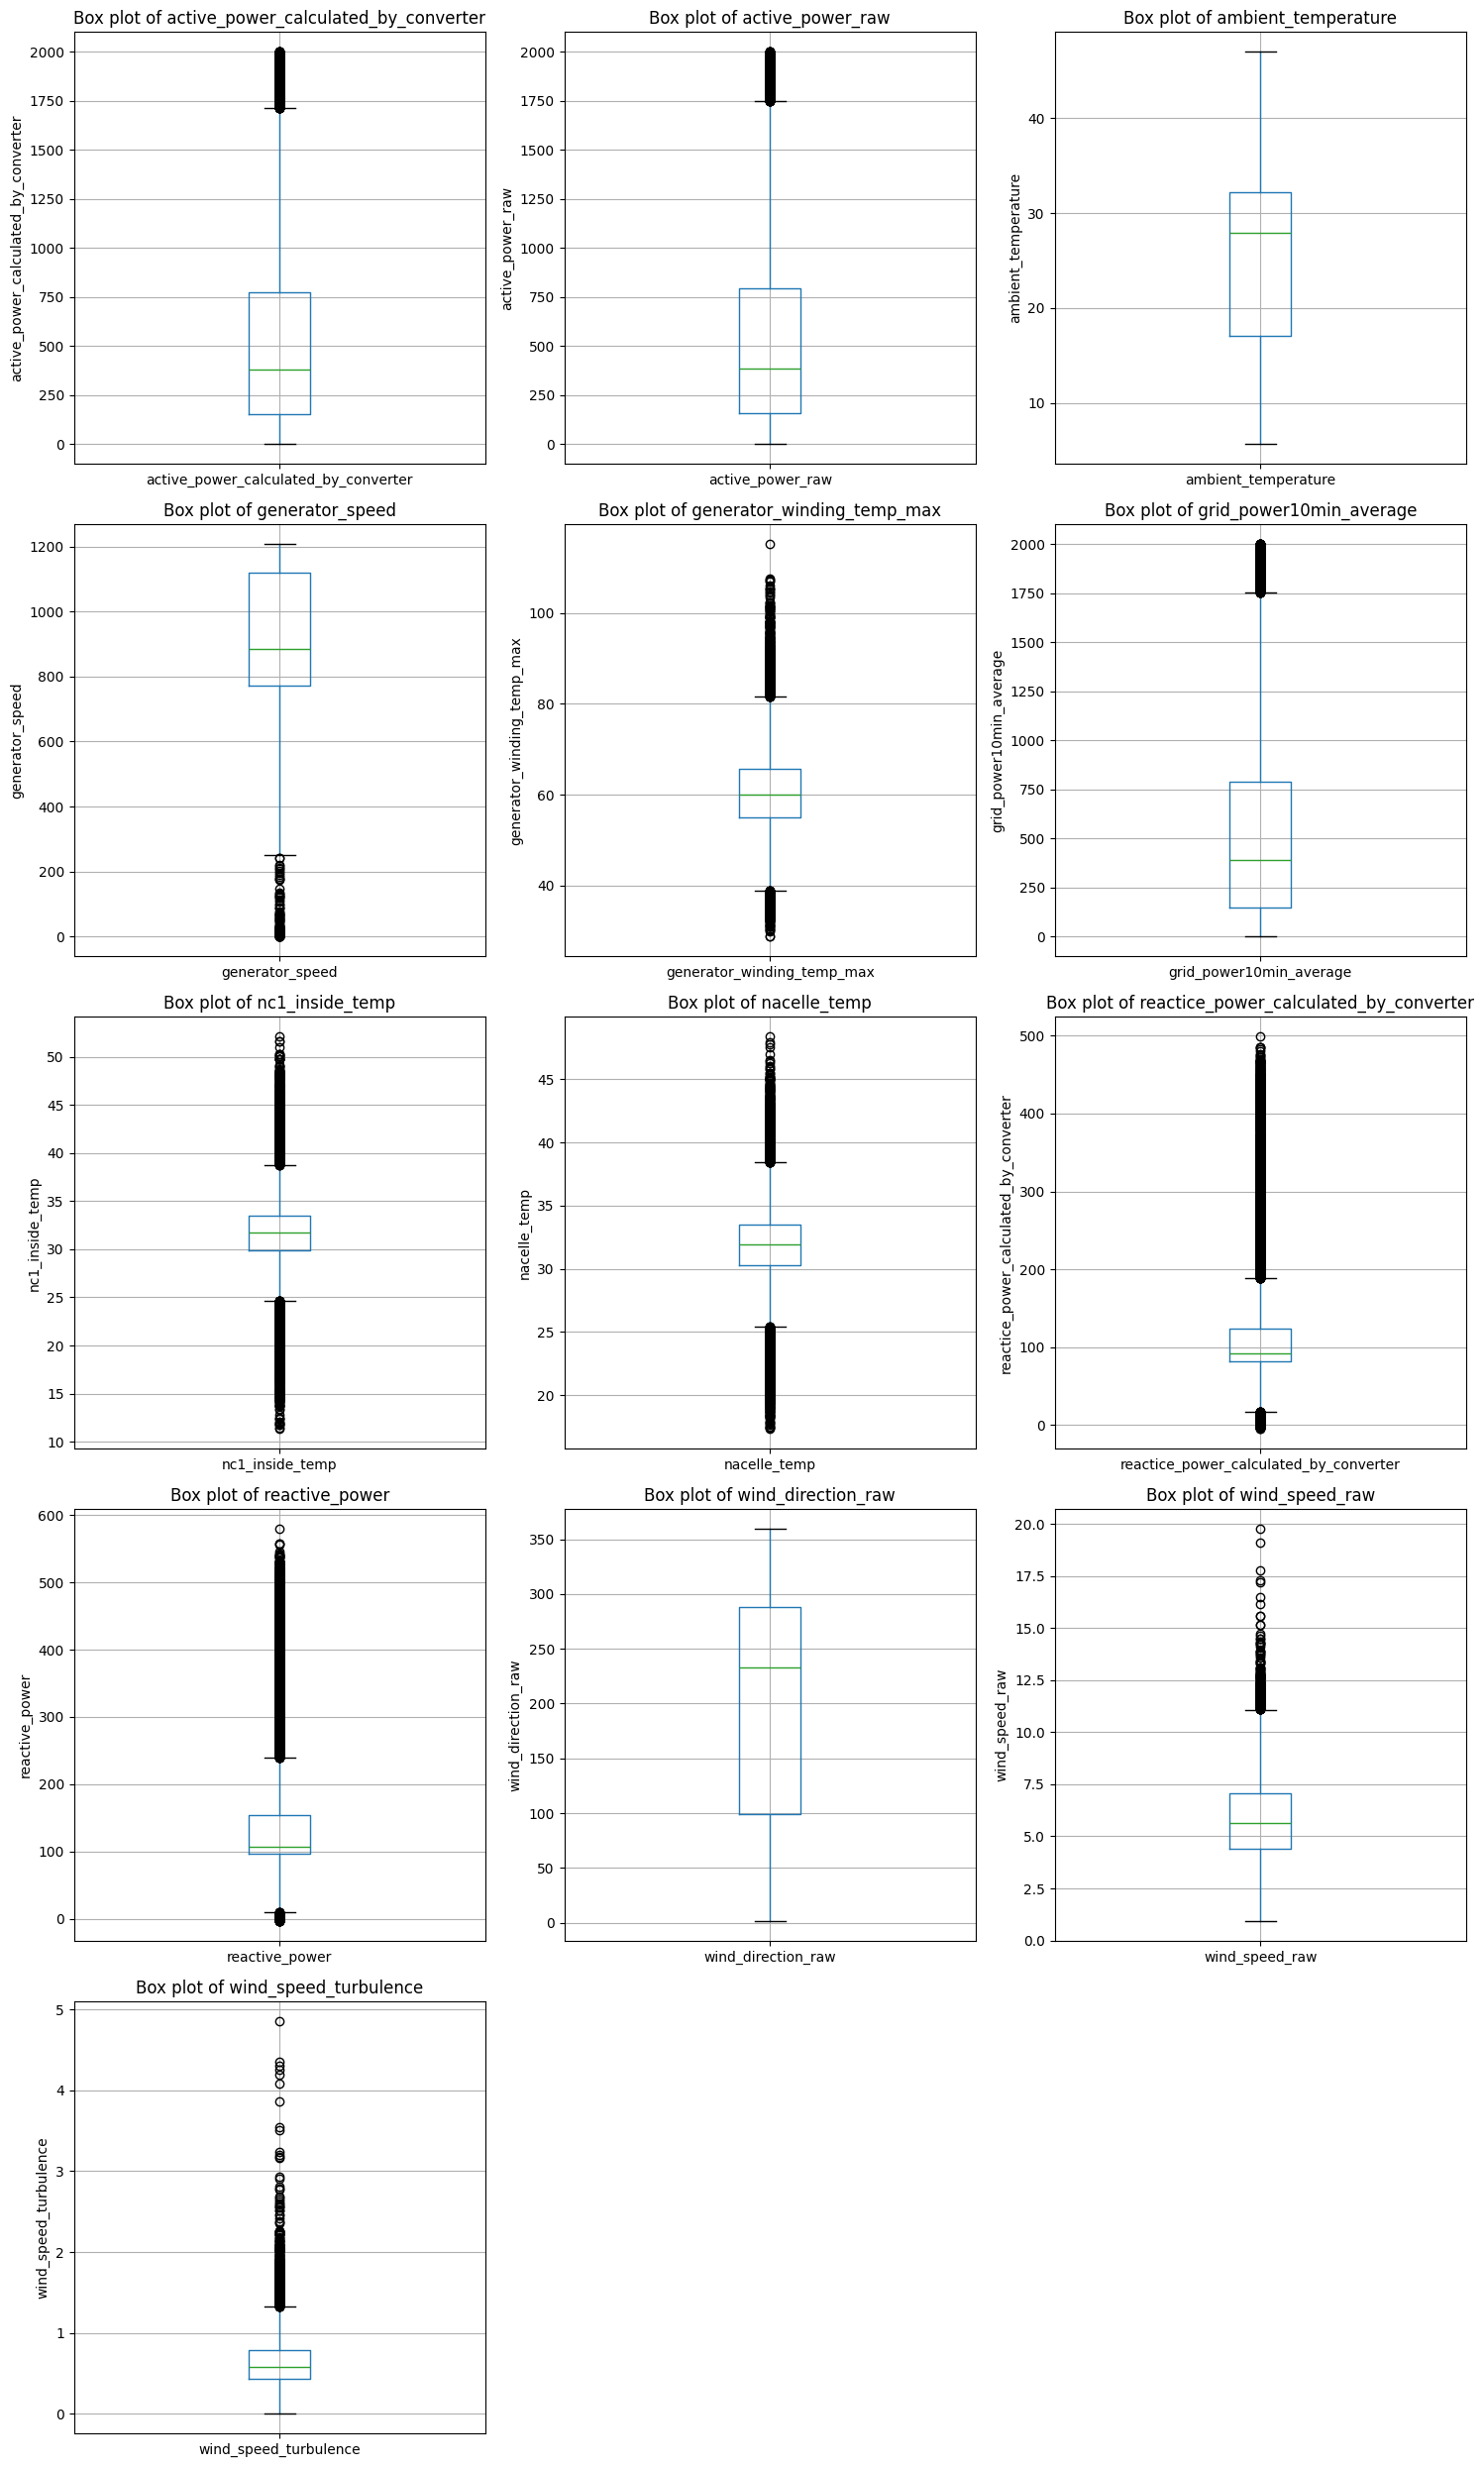


Applying Winsorization to handle outliers:
Winsorized 'active_power_calculated_by_converter' using bounds (1.49, 1921.90)
Winsorized 'active_power_raw' using bounds (5.94, 1909.27)
Winsorized 'ambient_temperature' using bounds (10.02, 39.32)
Winsorized 'generator_speed' using bounds (495.40, 1201.65)
Winsorized 'generator_winding_temp_max' using bounds (38.03, 88.49)
Winsorized 'grid_power10min_average' using bounds (0.73, 1865.99)
Winsorized 'nc1_inside_temp' using bounds (19.17, 44.33)
Winsorized 'nacelle_temp' using bounds (21.22, 41.25)
Winsorized 'reactice_power_calculated_by_converter' using bounds (-0.28, 414.89)
Winsorized 'reactive_power' using bounds (-0.20, 480.51)
Winsorized 'wind_direction_raw' using bounds (9.98, 350.73)
Winsorized 'wind_speed_raw' using bounds (2.46, 11.33)
Winsorized 'wind_speed_turbulence' using bounds (0.23, 1.68)

Generating box plots after outlier handling:


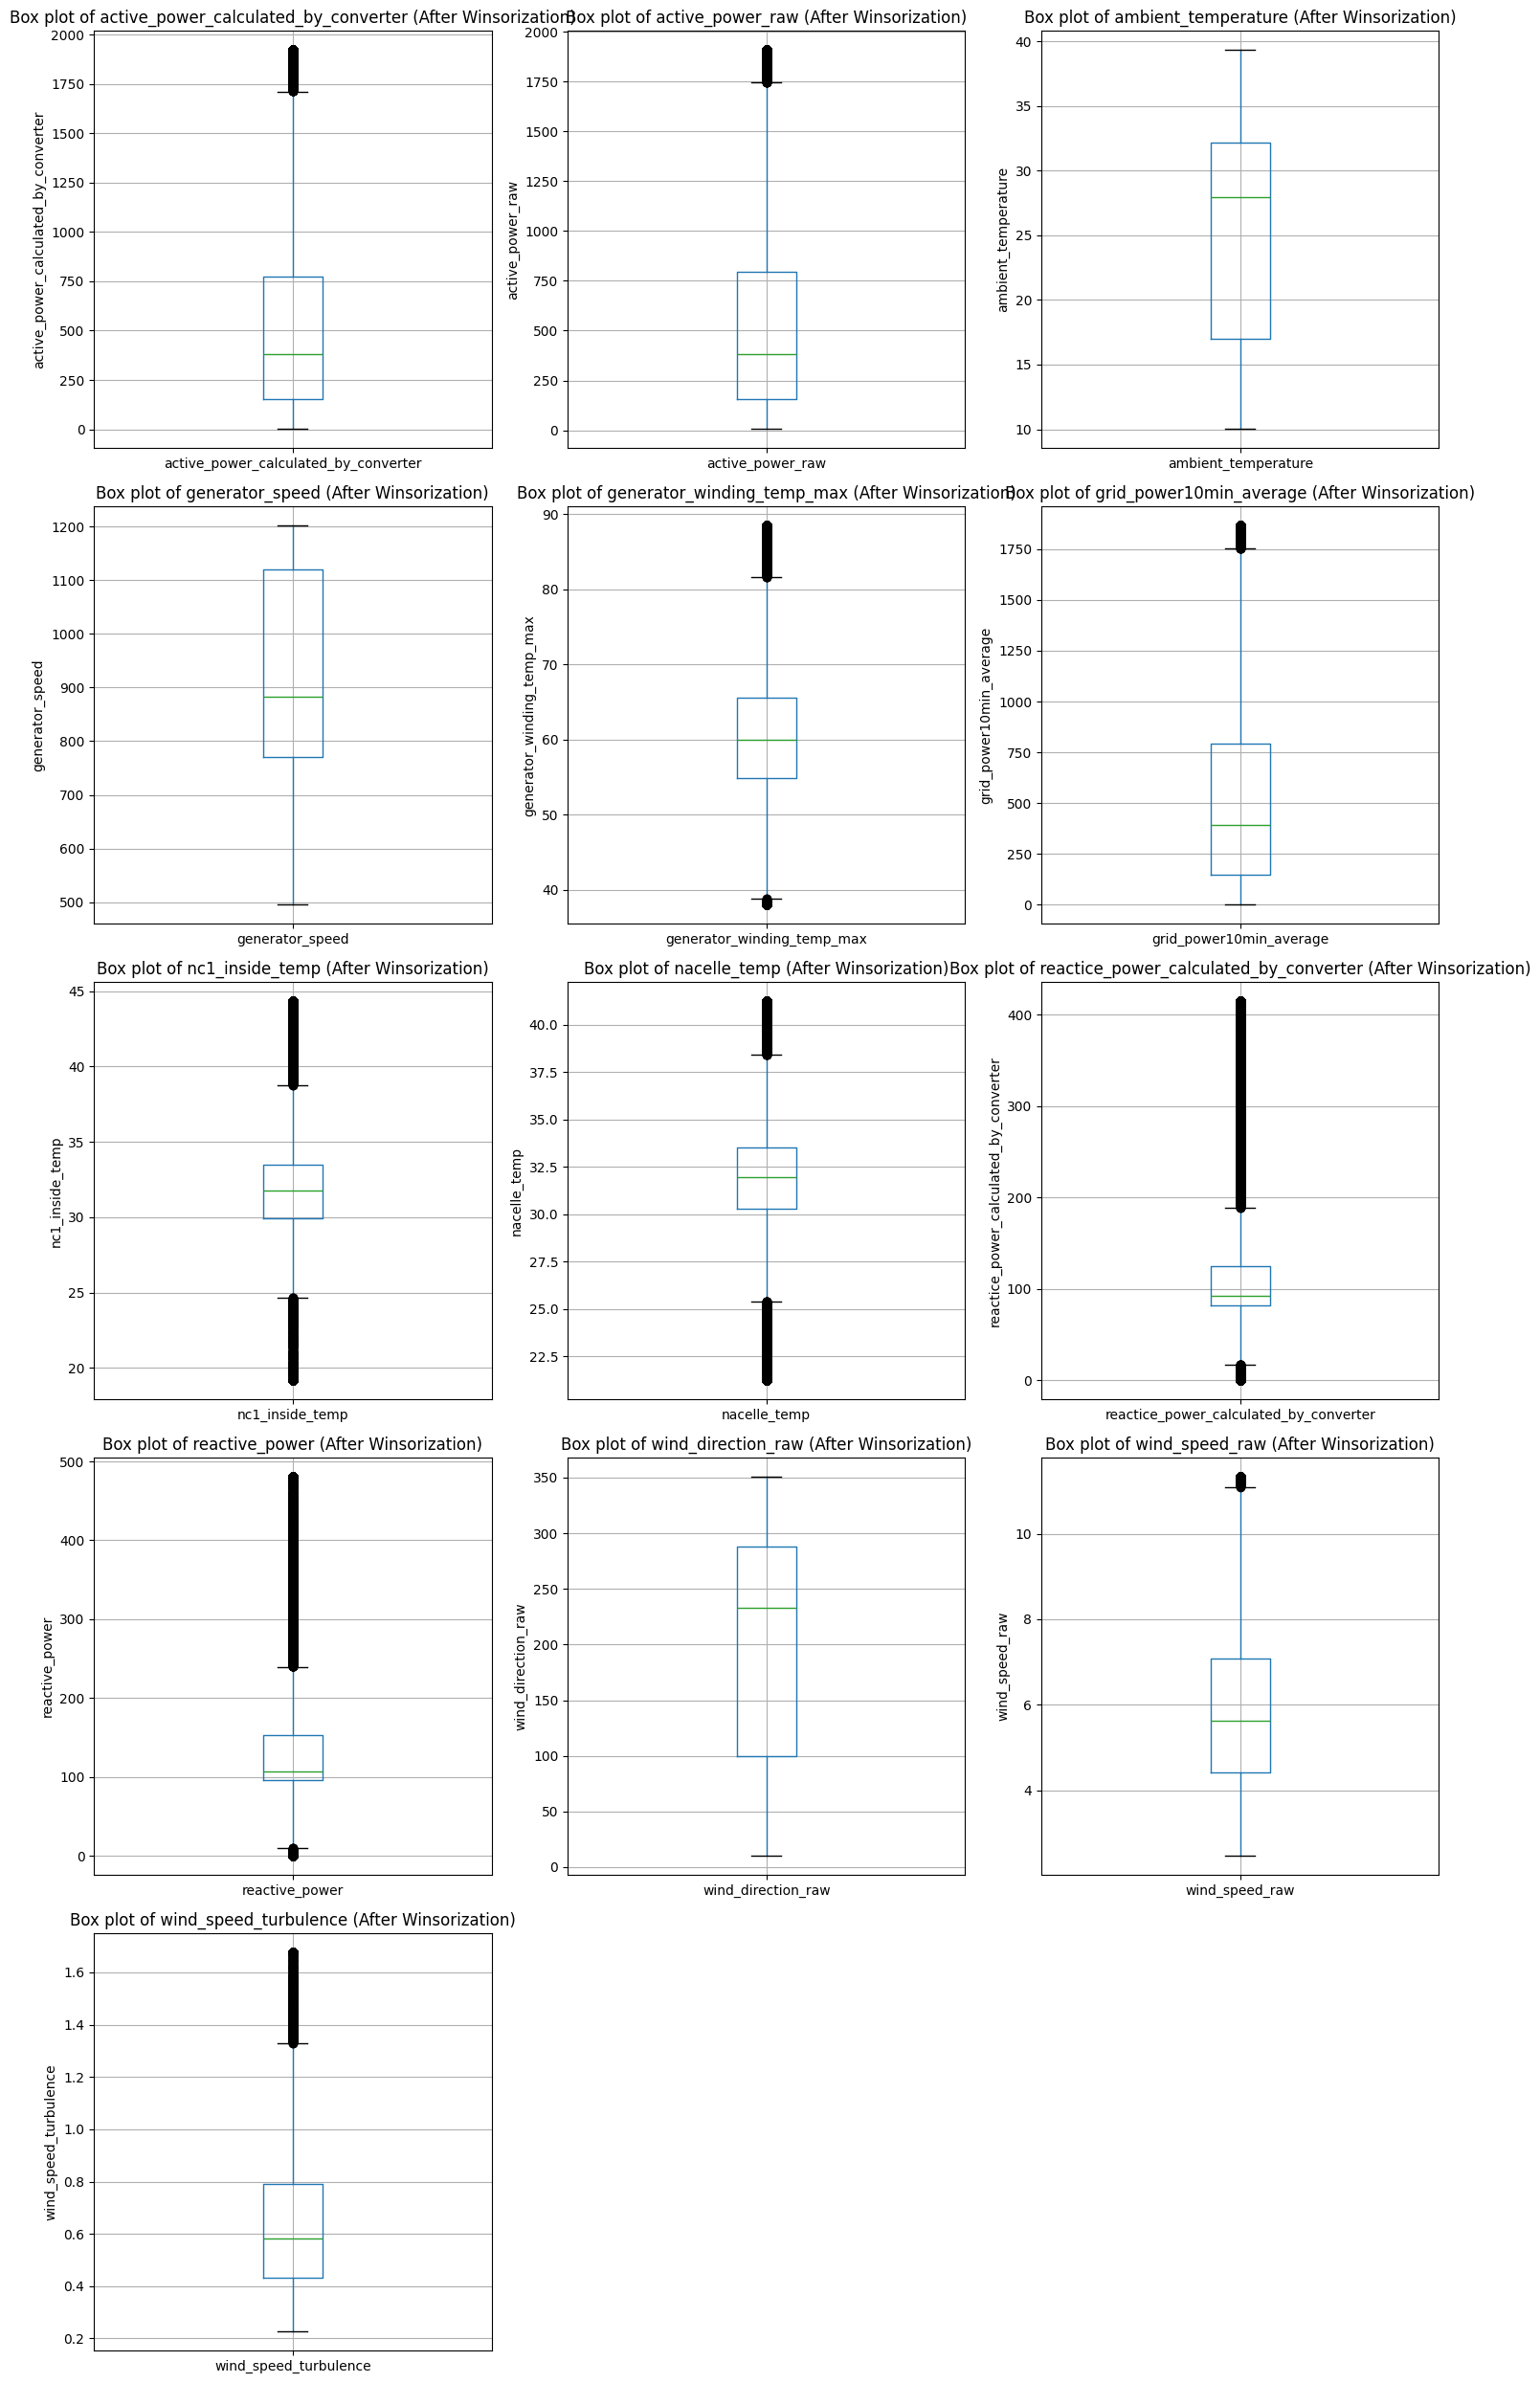

In [21]:
import matplotlib.pyplot as plt
# Identify potential numerical features for outlier detection
# Exclude 'timestamp' and 'turbine_id' and the target column
numerical_features = df.select_dtypes(include=np.number).columns.tolist()
numerical_features = [col for col in numerical_features if col not in ['timestamp', 'turbine_id', target_col]]

print("Numerical features selected for outlier detection:", numerical_features)

# Create box plots before handling outliers
print("\nGenerating box plots before outlier handling:")
num_cols = 3
num_rows = (len(numerical_features) + num_cols - 1) // num_cols
plt.figure(figsize=(15, num_rows * 5))
for i, feature in enumerate(numerical_features):
    plt.subplot(num_rows, num_cols, i + 1)
    df.boxplot(column=feature)
    plt.title(f'Box plot of {feature}')
    plt.ylabel(feature)
plt.tight_layout()
plt.show()

# Apply Winsorization to handle outliers for selected features
# Using 1st and 99th percentiles as bounds
print("\nApplying Winsorization to handle outliers:")
for feature in numerical_features:
    lower_bound = df[feature].quantile(0.01)
    upper_bound = df[feature].quantile(0.99)
    df[feature] = np.clip(df[feature], lower_bound, upper_bound)
    print(f"Winsorized '{feature}' using bounds ({lower_bound:.2f}, {upper_bound:.2f})")

# Create box plots after handling outliers to verify
print("\nGenerating box plots after outlier handling:")
plt.figure(figsize=(15, num_rows * 5))
for i, feature in enumerate(numerical_features):
    plt.subplot(num_rows, num_cols, i + 1)
    df.boxplot(column=feature)
    plt.title(f'Box plot of {feature} (After Winsorization)')
    plt.ylabel(feature)
plt.tight_layout()
plt.show()

  Split into Features (X) and Target (y)

In [26]:
# Convert the target column to a numeric type
df_processed[target_col] = pd.to_numeric(df_processed[target_col])

exclude_cols = ['timestamp', target_col]
X = df_processed.drop(columns=[col for col in exclude_cols if col in df_processed.columns])
y = df_processed[target_col]

In [27]:
# Ensure the target column is numeric before splitting
df_processed[target_col] = pd.to_numeric(df_processed[target_col])

exclude_cols = ['timestamp', target_col]
X = df_processed.drop(columns=[col for col in exclude_cols if col in df_processed.columns])
y = df_processed[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\nX_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

print("\nX_train dtypes:", X_train.dtypes.unique())
print("y_train dtype:", y_train.dtype)


X_train shape: (18181, 30)
X_test shape: (4546, 30)
y_train shape: (18181,)
y_test shape: (4546,)

X_train dtypes: [dtype('O')]
y_train dtype: float64


Train LightGBM Model

In [28]:
# Check Data Types Before Training
# Check datatypes of X_train and y_train
print("\n Checking data types before model training...")
print("Unique data types in X_train:", X_train.dtypes.unique())
print("y_train data type:", y_train.dtype)

# Ensure all feature columns are numeric
non_numeric_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()
if non_numeric_cols:
    print("\n Warning: Non-numeric columns detected in X_train:", non_numeric_cols)
    print("Attempting to convert them to numeric...")
    X_train[non_numeric_cols] = X_train[non_numeric_cols].apply(pd.to_numeric, errors='coerce').fillna(0)
    X_test[non_numeric_cols] = X_test[non_numeric_cols].apply(pd.to_numeric, errors='coerce').fillna(0)
    print(" Non-numeric columns converted to numeric successfully.")

# Ensure target is numeric
if not np.issubdtype(y_train.dtype, np.number):
    print("\n Target variable is not numeric. Converting...")
    y_train = pd.to_numeric(y_train, errors='coerce')
    y_test = pd.to_numeric(y_test, errors='coerce')
    print("Target converted to numeric successfully.")
# Train LightGBM Model
print("\nTraining LightGBM model...")
lgbm = lgb.LGBMRegressor(random_state=42)
lgbm.fit(X_train, y_train)
print(" Model training complete.")



 Checking data types before model training...
Unique data types in X_train: [dtype('O')]
y_train data type: float64

Attempting to convert them to numeric...
 Non-numeric columns converted to numeric successfully.

Training LightGBM model...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002611 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3347
[LightGBM] [Info] Number of data points in the train set: 18181, number of used features: 29
[LightGBM] [Info] Start training from score 46.301796
 Model training complete.


Evaluate Model

In [30]:
y_pred = lgbm.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n Model Evaluation Results:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R²  : {r2:.4f}")


 Model Evaluation Results:
RMSE: 1.4974
MAE : 1.0023
R²  : 0.6831


Optional: Scatter plot of Actual vs Predicted

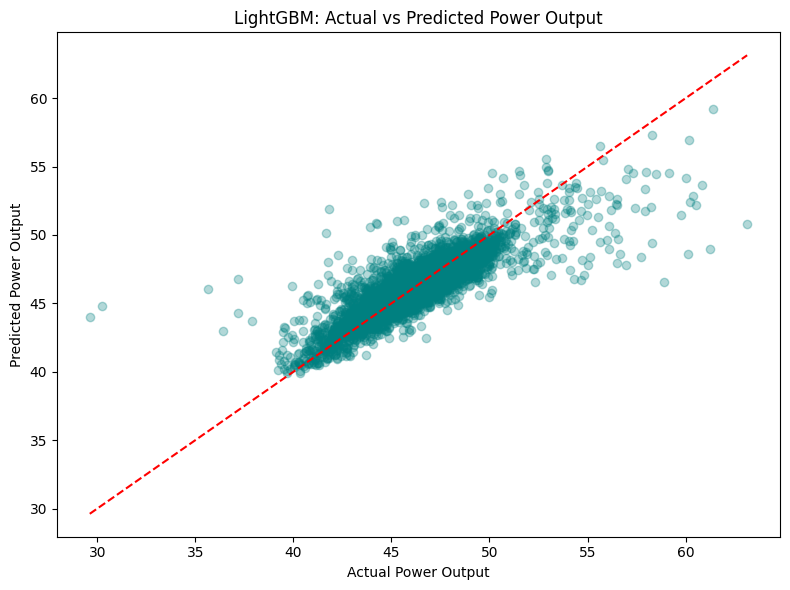

In [31]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.3, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Power Output")
plt.ylabel("Predicted Power Output")
plt.title("LightGBM: Actual vs Predicted Power Output")
plt.tight_layout()
plt.show()